In [1]:
import re
import pandas as pd
import seaborn as sns
import os
from matplotlib import rcParams
from matplotlib import pyplot as plt
sns.set()
rcParams['figure.figsize'] = 8, 12
%matplotlib inline

In [2]:
from seqeval.metrics import f1_score
from random import randint
from collections import namedtuple

In [3]:
resolved_archs = ['CNN_BiLSTM_CRF']

In [4]:
score_path = './neural_ner/results/conll/CNN_BiLSTM_CRF/active_checkpoint/random/00040805/score.txt'

In [5]:
splitter = re.compile(r'\s+')

def get_score(score_path:str) -> float:
    with open(score_path, 'rt') as fobj:
        lines = fobj.readlines()
        line = splitter.split(lines[1].strip())
        f1 = float(line[-1])
        return f1

get_score(score_path)

88.48

In [6]:
results_path = 'neural_ner/results/'

In [7]:
df_list = []
corpuses = os.listdir(results_path)
for corpus in corpuses:
    corpus_path = os.path.join(results_path, corpus)
    if not os.path.isdir(corpus_path):
        continue
    archs = os.listdir(corpus_path)
#     archs = [arch for arch in archs if os.path.isdir(arch)]
    for arch in archs:
        if arch not in resolved_archs:
            continue
        active_checkpoint = os.path.join(corpus_path, arch, 'active_checkpoint')
        
        strategies = os.listdir(active_checkpoint)    
        for strategy in strategies:
            strategy_path = os.path.join(active_checkpoint, strategy)
            iterations = os.listdir(strategy_path)
            iterations.sort()
            for i, iteration in enumerate(iterations):
                score_path = os.path.join(strategy_path, iteration, 'score.txt')
                if not os.path.exists(score_path):
                    continue
                f1 = get_score(score_path)
                df_list.append({'corpus': corpus, 'arch': arch, 'strategy': strategy, 'iteration': i, 'f1': f1})
#                 print({'corpus': corpus, 'arch': arch, 'strategy': strategy, 'iteration': i, 'f1': f1})



In [8]:
df = pd.DataFrame(df_list)
df['percentage'] = (df['iteration'] + 1) * 2

In [9]:
df.shape

(140, 6)

In [10]:
df.describe()

,iteration,f1,percentage
count,140.000000,140.000000,140.000000
mean,11.464286,85.420000,24.928571
std,7.154423,4.345886,14.308846
min,0.000000,69.400000,2.000000
25%,5.000000,83.025000,12.000000
50%,11.000000,84.125000,24.000000
75%,17.250000,89.367500,36.500000
max,24.000000,90.800000,50.000000


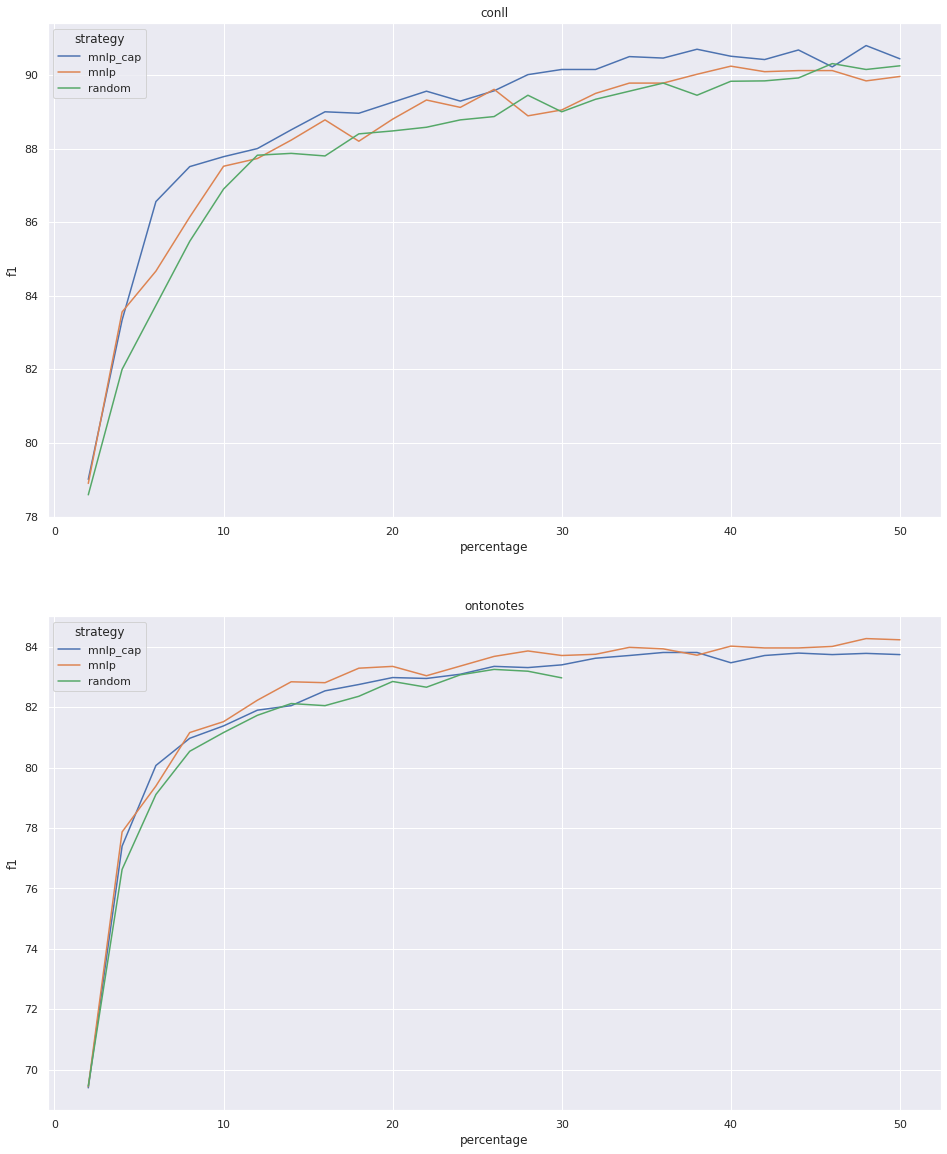

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 20)) 
sns.lineplot(ax=ax[1], data=df[df.corpus=='ontonotes'], x='percentage', y='f1', hue='strategy', legend='auto');
sns.lineplot(ax=ax[0], data=df[df.corpus=='conll'], x='percentage', y='f1', hue='strategy', legend='full');
ax[0].set_title('conll');
ax[1].set_title('ontonotes');

## Span based f1-measure

In [12]:
prd_path = './neural_ner/results/ontonotes/CNN_BiLSTM_CRF/active_checkpoint/mnlp_cap/00044021/pred.txt'

In [13]:
# Labels = namedtuple('Labels', 'y_true y_pred')

def eval_f1(prd_path: str) -> float:
    with open(prd_path, 'rt') as fobj:
        valid = fobj.read()
    valid = [p.strip() for p in valid.split('\n\n') if p]
    assert len(valid) == 15680
    y_true = []
    y_pred = []
    for sent in valid:
        t_pred = []
        t_true = []
        for token in sent.split('\n'):
            token = token.split()

            t_pred.append(token[1].strip())
            t_true.append(token[2].strip())
        y_true.append(t_true)
        y_pred.append(t_pred)
    return f1_score(y_true, y_pred)
        
eval_f1(prd_path)

0.6930722226312303